# General Instructions

To run each cell of Collab just press the play button (image.png) or simply press:

`Shift + Enter`


---

 **NOTE**: To use the GPU, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---



# Why model fine-tuning is not always the best answer? Can you think of reasons?


1. Can take a lot of time
2. May require additional ("labeled") data
3. Needs human expertise
4. Needs (sometimes expensive) infrastructure
5. Might not always reach the desired levels of accuracy
6. ...



# An alternative strategy:

1. Give data to the model (e.g., an external Data Set like ICD-O-3 manual)
2. The model can see these data in its input
3. The model can use these data in its response without
4. The model thus produces "informed" answers

# Installing dependencies

In [ ]:
!pip install --upgrade langchain==0.2.5 langchain-community==0.2.5 sentence-transformers==3.0.1 chromadb==1.0.15 setuptools #colab-xterm
!pip install llama-cpp-python==0.3.16 --extra-index-url https://abetlen.github.io/llama-cpp-python/whl/cu124


 ---

 **NOTE:** After installing the dependences, you need to restart session (click "Runtime" on the top menu and go to the relevant button)

 ---



# Packages

In [ ]:
import textwrap
import pandas as pd
from langchain_core.prompts import PromptTemplate
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import SentenceTransformerEmbeddings
from langchain.chains import LLMChain
from langchain import LlamaCpp

# Downloand a Large Language Model

model card: https://huggingface.co/microsoft/Phi-3-mini-4k-instruct-gguf

Fast Phi3 model

In [ ]:
!wget https://huggingface.co/microsoft/Phi-3-mini-4k-instruct-gguf/resolve/main/Phi-3-mini-4k-instruct-q4.gguf

In [ ]:
llm = LlamaCpp(
    model_path="Phi-3-mini-4k-instruct-q4.gguf",
    n_gpu_layers=-1, # use all available GPU
    max_tokens=1000, # maximum number of output tokens
    n_ctx=2048, # context window (max number of tokens)
    seed=42, # for reproducibility
    verbose=False
)

# Load Data

We are going to use Common Terminology Criteria for Adverse Events v4.0 (CTCAE).

Source: https://evs.nci.nih.gov/ftp1/CTCAE/CTCAE_4.03/Archive/CTCAE_4.0_2009-05-29_QuickReference_8.5x11.pdf

Data already on github repo:


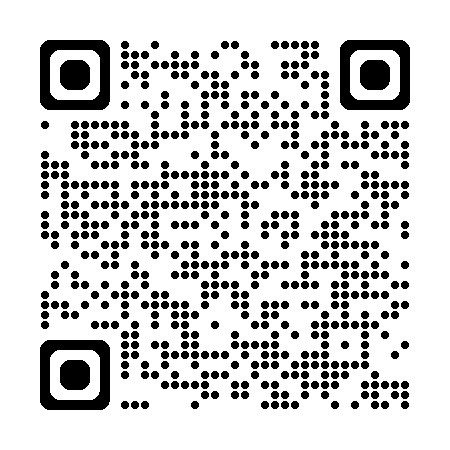


Common Terminology Criteria look like this (pdf form):

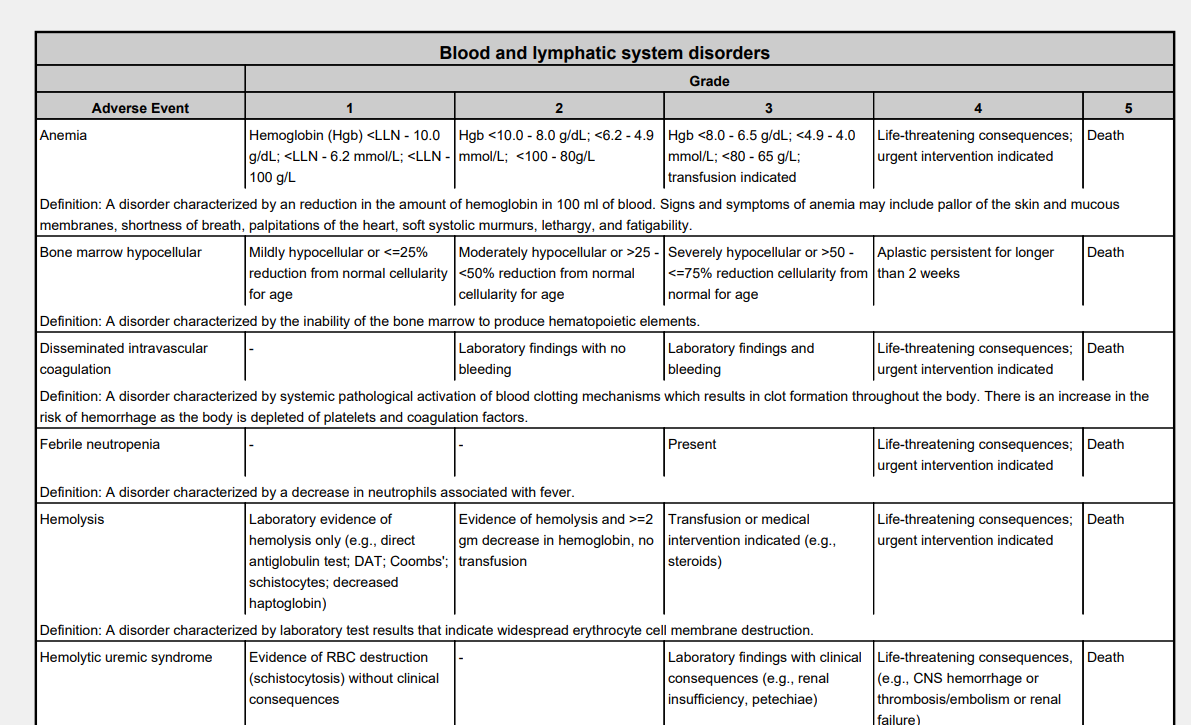

In [ ]:
url = "https://github.com/IKNL/iacr_2025_llm_workshop/raw/refs/heads/main/data/CTCAE_v4.xlsx"
ctcae = pd.read_excel(url)

#Let's have a look at the data (tabular form):
ctcae.head()

# Let's prepare the data

We have two types of info:

*   Names of Adverse Events (AE)
*   Definitions of AE
*   Gradings and their criteria

We need to prepare each AE to be a "chunk" of relevant information. This is sometimes done through "Splitters" in an automatic way, but since we know here that each AE is an "exhaustive" entry of our Data Base, we will create a long piece of text corresponding to each AE.

In [ ]:
definitions = ctcae['Name'] + ' is ' + ctcae['Definition'].apply(lambda x: "[No definition provided.]" if pd.isna(x) else x.lower())

# do the same for gradesbbb
gradings = " The grading criteria for this adverse effect is as follows: " + \
' Grade 1: ' + ctcae['Grade1'].apply(lambda x: "[No text provided.]" if pd.isna(x) else x)  + \
'. Grade 2: ' + ctcae['Grade2'].apply(lambda x: "[No text provided.]" if pd.isna(x) else x)  + \
'. Grade 3: ' + ctcae['Grade3'].apply(lambda x: "[No text provided.]" if pd.isna(x) else x)  + \
'. Grade 4: ' + ctcae['Grade4'].apply(lambda x: "[No text provided.]" if pd.isna(x) else x)  + \
'. Grade 5: ' + ctcae['Grade5']

database_ctcae = (definitions + gradings).tolist()

In [ ]:
# We created a big list (i.e., a collection of Definitions and their respective gradings). Let's have a look at the first three:
database_ctcae[:3]

# Retrieval-Augmented Generation (RAG)

## Introduction
RAG is a technique increasing used in LLMs that generate text (e.g., chatbots). Assume that you type an input text to a chatbot. RAG is a process that involves two steps:

*   Retrieval of relevant information based on the input text
*   Generation of text based on the retrieval

RAG can be a simple or a complicated pipeline. Here we will work on the so-called "naive" RAG pipeline shown below:

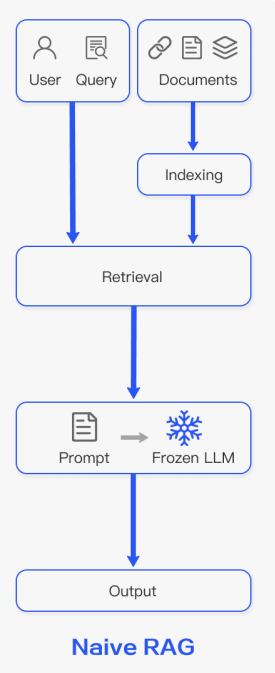

(source: https://arxiv.org/abs/2312.10997)

---







For example, suppose you ask the chatbot about specific cancer information (we will see this in a moment), which the chatbot has not seen in its training data or is still unable to correctly identify in its output (e.g., because it is a small model with only a few parameters, and therefore its performance is not stellar). RAG allows you to "plug in" a data base (DB) to the model, such as a cancer-specific guideline or research papers and therefore it helps the model produce good-quality responses. In this example, RAG means:

1.    The most relevant cancer information from the DB are retrieved
2.    These retrievals are put within the prompt (input) of the LLM
3.    The model is instructed to base its responses to the retrievals put in the context (prompt-engineering; see below)

---

## Why is RAG important?
RAG is has nice features that make it useful for LLMs and evidence-based search in general:

* Accuracy: By grounding responses in retrieved documents, RAG reduces "hallucinations" (made-up inaccurate LLM responses).
* Domain adaptation: You can connect LLMs to specialized or private datasets (like the CTCAE database)
* Up-to-date answers: LLMs are trained on data up to a certain point and can't know recent facts. RAG lets them access the latest information from external sources.
* Most importantly, efficiency: RAG avoids the need to retrain LLMs (a costly and technically difficult procedure)



Example of RAG for cancer information (source: https://cancer.jmir.org/2025/1/e70176):

<div align="center">

> *"For the chatbots that used information from CIS, the hallucination rates were 0% for GPT-4 and 6% for GPT-3.5, whereas those for chatbots that used information from Google were 6% and 10% for GPT-4 and GPT-3.5, respectively […] The hallucination rates for conventional chatbots were approximately 40%."*
> <br><br>
> Nishisako S, Higashi T, Wakao F<br>
> **Reducing Hallucinations and Trade-Offs in Responses in Generative AI Chatbots for Cancer Information: Development and Evaluation Study**<br>
JMIR Cancer 2025;11:e70176;
> doi: 10.2196/70176

</div>

---

## STEP 1: Data Retrieval

In RAG, the first step is to retrieve the most relevant information from a data base (DB). However, since computers are good with numbers, the retrieval happens at the level of embeddings (that's why we need LLMs for that!). Therefore, the steps are as follows:

1. We have prepared chunks of relevant information
2. We transform these chunks into embeddings:

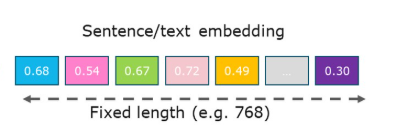

3. We transform our query into an embedding too
4. We compare the query embedding with the chunk embeddings
5. We retrieve the "most similar" embedding(s) from the DB to our query
6. We retrieve the respective chunks of text corresponding to "most similar" embedding(s)  

### We create a DB of embeddings
We use a specific library called LangChain (https://www.langchain.com/).

LangChain is an open-source Python framework designed to  build applications powered by LLMs like GPT, Llama, etc. It is very powerful and can be used for simple applications (like our RAG) to even AI Agents.

Here we use a specific LLM to create embeddings from the CTCAE data. The model called "all-MiniLM-L6-v2" comes from sentence transformers which is used to create embeddings of sentences or small paragraphs. Model card: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

In [ ]:
from langchain_core.documents import Document

# We create "Documents" from AE chunks (Documents are native LangChain objects)
documents = [Document(page_content=str(entry)) for entry in database_ctcae]

# This cleans the DB in case we have things stored there before (in case we recreate the DB)
Chroma(
    persist_directory="db"
).delete_collection()

# This creates the embeddings DB
vectorstore = Chroma.from_documents(
    documents=documents,
    embedding=SentenceTransformerEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2" # general language model
        #model_name="neuml/pubmedbert-base-embeddings" # pubmed specific model
    ),
    persist_directory="db",
)

## STEP 2: Prompt engineering

### Main Components of Prompt Engineering

- **Role/Persona**  
  Defining the model’s role or perspective (e.g., "Act as a medical doctor", "You are a helpful cancer assistant ").

- **Instruction/Task**  
  Clear guidance on what you want the model to do (e.g., "Summarize this text", "Find the ICD-O-3 code").

- **Context**  
  Background information or relevant data to help the model understand the task (e.g., sample data, or an excerpt from a medical Data Base). This is where RAG comes in.

- **Input Data**  
  The specific text, code, or data you want the model to process.

- **Output Format**  
  Specification of the desired format for the response (e.g., list, table, maybe style of the text [e.g., medical doctor]).

- **Constraints**  
  Any rules or limitations (e.g., word limit, style, tone, language).

- **Examples (Few-shot Learning)**  
  Sample inputs and outputs to guide the model’s behavior. This will allow the model to "learn" from these examples, without actually training the model.


Note: this is not the best way to order the prompt neccessarily. It is a matter of trial and error. Try out different prompt templates and see how they look.



In [ ]:
templateQA_trial1 = """
Respond to the following question based on the context.

CONTEXT
{context}

QUESTION:
{question}
"""


In [ ]:

templateQA_trial2 = """
<|user|>ROLE:
ROLE:
You are a medical assistant chatbot trained to help users understand adverse events based on the Common Terminology Criteria for Adverse Events (CTCAE).

TASK:
You use a specialized knowledge base that includes the official CTCAE definitions and grading of adverse events, to respond to questions about adverse events.

RETRIEVED CTCAE CONTEXT:
{context}

QUESTION:
{question}<|end|>
<|assistant|>
"""


In [ ]:

templateQA_trial3 = """
<|user|>ROLE:
You are a medical assistant chatbot trained to help users understand adverse events based on the Common Terminology Criteria for Adverse Events (CTCAE).

TASK:
You use a specialized knowledge base that includes the official CTCAE definitions and grading of adverse events, to respond to questions about adverse events.

INSTRUCTIONS:
1. Use the retrieved CTCAE definitions and grading provided in the context below
2. Identify which context information is relevant to the question(s)
3. Use only the relevant context information to answer the question(s)
4. Reference the retrieved CTCAE information to support your response

RETRIEVED CTCAE CONTEXT:
{context}

QUESTION:
{question}<|end|>
<|assistant|>
"""


In [ ]:

templateQA = """
<|user|>
ROLE:
You are a medical assistant chatbot trained to help users understand adverse events based on the Common Terminology Criteria for Adverse Events (CTCAE).

TASK:
You use a specialized knowledge base that includes the official CTCAE definitions and grading of adverse events, to respond to questions about adverse events.

INSTRUCTIONS:
1. Use the retrieved CTCAE definitions and grading provided in the context below
2. Identify which context information is relevant to the question(s)
3. Use the relevant context to answer the question(s)
4. Reference the retrieved CTCAE information to support your response

GUIDELINES:
- Base your responses strictly on the retrieved CTCAE context provided below
- Do not infer or assume any information not present in the context below
- If the retrieved context doesn't contain relevant information to the question, state this clearly "I do not know"

RETRIEVED CTCAE CONTEXT:
{context}

QUESTION:
{question}<|end|>
<|assistant|>
"""


In [ ]:
#question = "What is anemia?"
#question = "what is the difference between grade 2 and 3 in anemia?"
#question = "which is the adverse effect where breathing stops during sleep?" #Just give the name of the Event"
#question = "Hemoglobin is too high. which adverse effect is this?"
question = "Which  grade is it when Hemoglobin is 4.1 gm/dL above baseline?"
#question = "Determine grade 4 of high cholesterole" # why this fails?
#question = "Intraoperative information in the head and brain"
#question = "THe hemorrhage occured after the surgery; is this defined as Intraoperative or Postoperative?"
#question = "which adverse effects relate to the eye?" #just list and explain which ones you exclude."

## STEP 3: Retrieval fo relevant information

In [ ]:
context = vectorstore.similarity_search(question, k=2) # K refers to the number of most relevant text chunks that are retrieved
context

## STEP 4: Set up an LLM chain

In [ ]:
prompt_template = PromptTemplate(
    template=templateQA,
    input_variable=["context", "question"],
)
llm_chain = LLMChain(llm=llm, prompt=prompt_template)

## STEP 5: Give input to the LLM and produce text

In [ ]:
qa_chain = llm_chain.invoke({"context": " ".join([i.page_content for i in context]), "question": question})
print(qa_chain['text'])


In [ ]:
#import textwrap
#print(textwrap.fill(qa_chain['text'], width=88))

# Things to keep in mind when using RAG

1. Many degrees of freedom in the pipeline:
    1. Chunks (size, overlap, ...)
    2. Embeddings model (medical or not, ...)
    3. How many most relevant chunks to give to the LLM? (1, 2, 10, 100...)
    4. Which LLM to use for text production?
    5. Use more complicated techniques (e.g., text translation? chunk reranking? chunk rewriting? ...)

2. Unclear what works best in every situation (i.e., trial and error)
3. Context window and text production time can be an issue for local (self-hosted) models
4. Data structure matters a lot [why?]

# Let's do the same for Cancer Registry information

Cancer in 5 Continents! (2024 edition). Source: https://ci5.iarc.fr/ci5-xii/


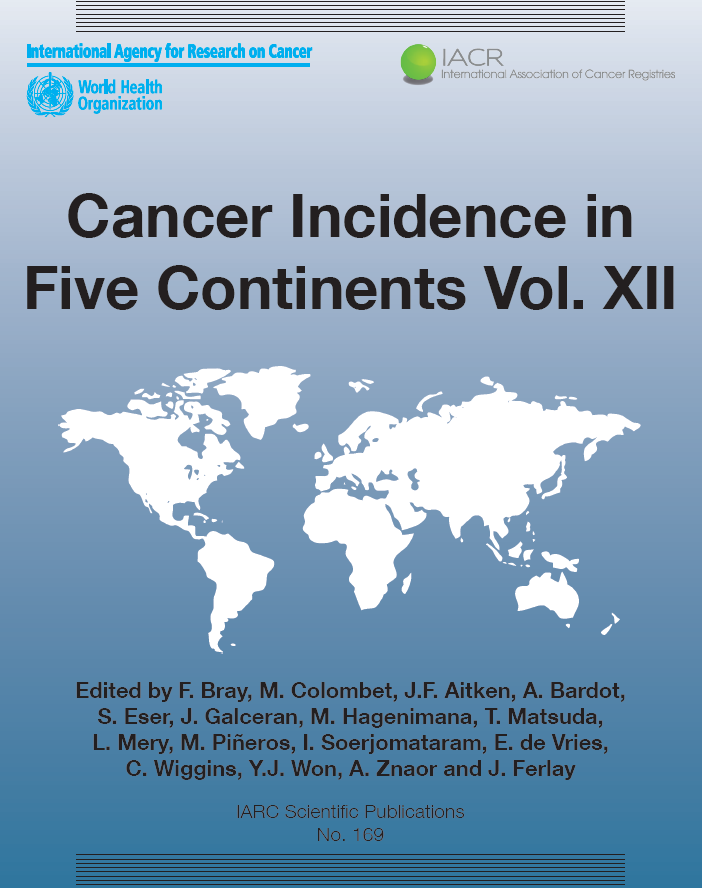


An example of the data:

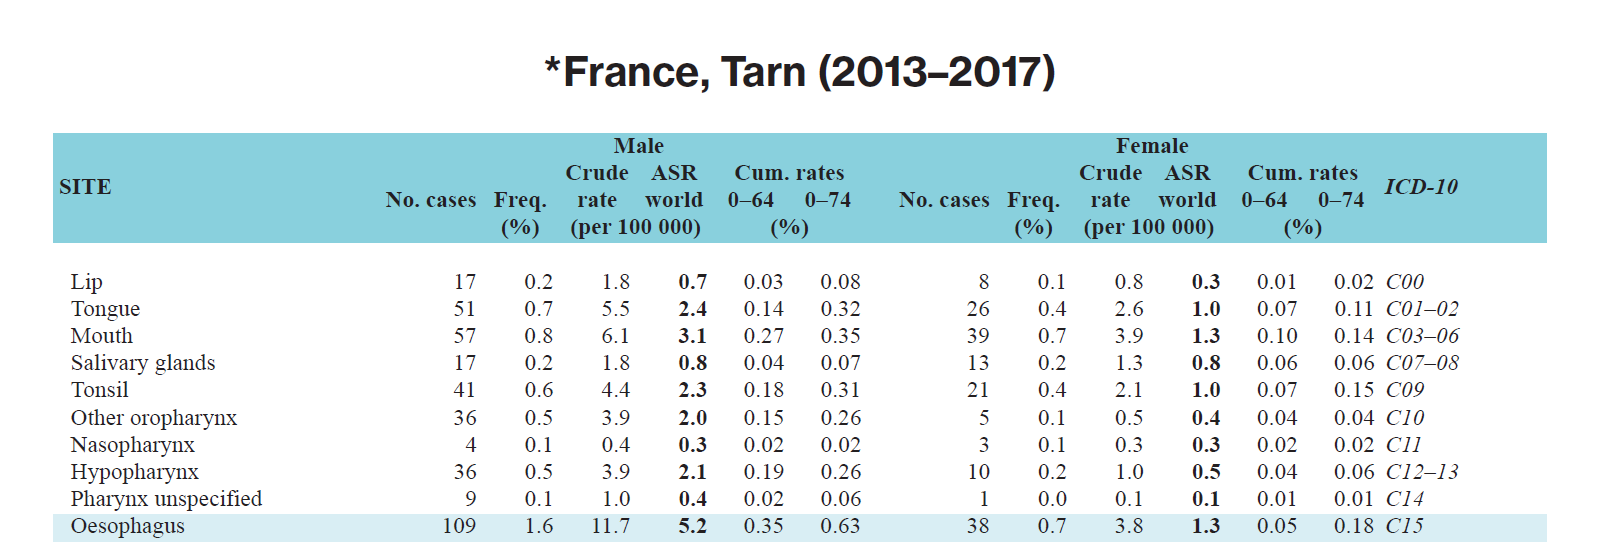

# Goal

Create a chabot that responds to questions about cancer rates based on the CI5 publication.

* Comparisons between countries are tedious when searching through a PDF document
* CI5 have 2000+ of pages full of tables and numbers
* RAG can help us summarize important information across/within countries
* We do not need a model trained on medical/cancer data, RAG will do a similar job

In [ ]:
url = "https://github.com/IKNL/iacr_2025_llm_workshop/raw/refs/heads/main/data/CI5_ASR_CR_specific_countries.xlsx"
ci5 = pd.read_excel(url)

#Let's have a look at the data (tabular form):
ci5.head()

## Data

Only 4 countries across the world selected for illustration purposes.

In [ ]:
ci5['registry_name'].unique()

## How to chunk information?

I decided to create chunks, each containing cancer registry (CR) information along with gender, specific cancer and age-standardized rate (ASR)

In [ ]:
ci5_chunks = ci5['cancer_name'] + " cancer " + 'in the ' + ci5['sex'] + ' population of ' + ci5['registry_name'] + " has age-standardized rate (ASR): " + ci5['age_standardized_rate'].astype('str') + " per 100000 people." #(classified as " + ci5['icd-10'] + "in ICD10)"


ci5_chunks = ci5_chunks.tolist()

In [ ]:
ci5_chunks[:3]

In [ ]:
llm = LlamaCpp(
    model_path="Phi-3-mini-4k-instruct-q4.gguf",
    n_gpu_layers=-1, 
    max_tokens=1000, 
    n_ctx=4096, # we make the context window larger to accomodate more data
    seed=42, 
    verbose=False
)

In [ ]:
# We create "Documents" from AE chunks (Documents are native LangChain objects)
documents_ci5 = [Document(page_content=str(entry)) for entry in ci5_chunks]

# This cleans the DB in case we have things stored there before (in case we recreate the DB)
Chroma(
    persist_directory="db_CI5"
).delete_collection()

# This creates the embeddings DB
vectorstore_ci5 = Chroma.from_documents(
    documents=documents_ci5,
    embedding=SentenceTransformerEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2" # general language model
        #model_name="neuml/pubmedbert-base-embeddings" # pubmed specific model
    ),
    persist_directory="db_CI5",
)

In [ ]:
templateQA_CI5 = """
<|user|>
ROLE:
You are a medical assistant chatbot trained to help users go through the Cancer Incidence in Five Continents publication (abbreviation CI5). This is a publication from the International Agency for Research on Cancer that publishes cancer incidence across countries in the world.

TASK:
You use the figures from the CI5 publication that includes age standardized cancer rates (ASR) based on the country, sex and type of cancer, to answer questions about cancer incidence.

INSTRUCTIONS:
1. Use the retrieved CI5 information provided in the context below
2. Identify which context information is relevant to the question(s)
3. Use the relevant context to answer the question(s)
4. Reference the retrieved CI5 information to support your response

GUIDELINES:
- Base your responses strictly on the retrieved CI5 context provided below
- Do not infer or assume any information not present in the context below
- If the retrieved context doesn't contain relevant information to the question, state this clearly "I do not know"

RETRIEVED CI5 CONTEXT:
{context}

QUESTION:
{question}<|end|>
<|assistant|>
"""


In [ ]:
#question = "Which area has the highest ASR in canada in breast cancer? only consider females."
question = "Has singapore higher ASR of liver cancer in comparison to canada, mauritius, or finland? make a table"

context = vectorstore_ci5.similarity_search(question, k=45) # K refers to the number of most relevant text chunks that are retrieved
print("CONTEXT:")
print("\n".join([i.page_content for i in context]))
print("---"*100)

prompt_template = PromptTemplate(
    template=templateQA_CI5,
    input_variable=["context", "question"],
)
llm_chain_ci5 = LLMChain(llm=llm, prompt=prompt_template)

qa_chain = llm_chain_ci5.invoke({"context": " ".join([i.page_content for i in context]), "question": question})
print("ANSWER:")
#print(textwrap.fill(qa_chain['text'], width=100))
print(qa_chain['text'])
